 - combinar las tablas
 - limpiar datos
 - combinar las columnas title, brand, summary, description en una nueva columna
 - tokenizar la nueva columnas combinada
 - calcular similitud con la similitud de los items tokenizados del coseno
 - ordenar descendentemente los items similares => lista 1
 - los que son muy similares los eliminamos de la lista
 - agarramos algunos items de la lista y calculamos el mean del overall
 - ordenamos nuevamente descendentemente pero esta vez basados en el overall mean => lista2
 - recomendamos los 10 primeros de la lista 2



In [2]:
import nltk
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = 'C:/Users/coraj/Documents/fuzzy-recommendation-system-/AMAZON_FASHION.json.gz'

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(PATH)

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN


In [5]:
df.shape

(883636, 12)

In [6]:
PATH = 'C:/Users/coraj/Documents/fuzzy-recommendation-system-/meta_AMAZON_FASHION.json.gz'

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_meta = getDF(PATH)
df_meta.head()


,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XCC Qi promise new spider snake preparing men'...,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Magical Things I Really Do Do Too!,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[For the professional or amateur magician. Ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Ashes to Ashes, Oranges to Oranges",Flickerlamp Publishing,[Package Dimensions:\n \n8....,"19,734,184inClothing,ShoesJewelry(",5 star,1940735033,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aether & Empire #1 - 2016 First Printing Comic...,NaN,[Package Dimensions:\n \n10...,"10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,$4.50,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
tablas_combinadas = pd.merge(df, df_meta, on='asin', how='left')
pd.set_option('display.max_columns', None)
tablas_combinadas.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,title,brand,feature,rank,date,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
tablas_combinadas['vote'][0]

nan

In [9]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in tablas_combinadas.columns]

if existing_columns:
    # Al menos una de las columnas en 'existing_columns' existe en el tablas_combinadasFrame 'tablas_combinadas'.
    # Puedes combinar las columnas existentes y crear la nueva columna 'combined_text'.
    tablas_combinadas['combined_text'] = tablas_combinadas[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)

In [10]:
tablas_combinadas = tablas_combinadas[:50]

In [11]:
tablas_combinadas['similar_item'].value_counts()

Series([], Name: count, dtype: int64)

Text(0, 0.5, 'Count')

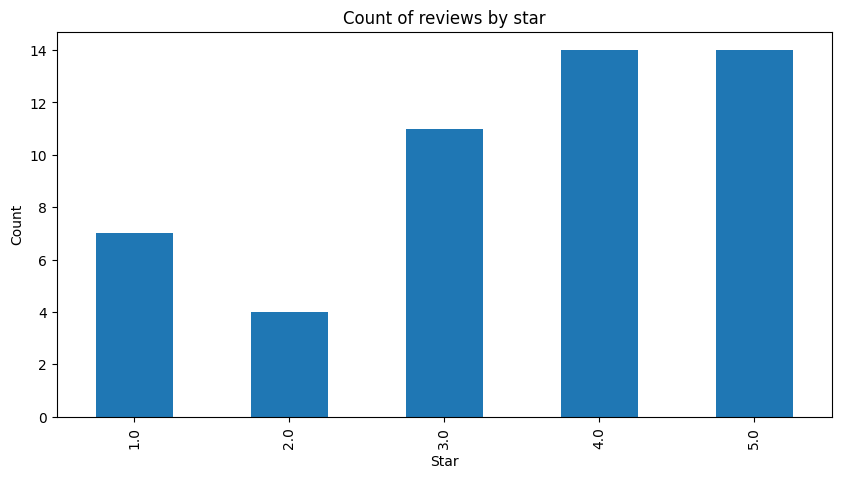

In [12]:
ax = tablas_combinadas['overall'].value_counts().sort_index().plot(kind='bar', title="Count of reviews by star",figsize=(10, 5))
ax.set_xlabel("Star")
ax.set_ylabel("Count")


notamos que los reviews estan sesgados hacia 5 estrellas

### Tokenizacion de comentarios

In [13]:
example = tablas_combinadas['reviewText'][39]
example

'Wonderful item. I have purchased several of these. They last forever unless you lose them.  I am happy with my purchase Buxton is made to last.'

In [14]:
nltk.download('punkt')
tokens = nltk.word_tokenize(example)
tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Wonderful',
 'item',
 '.',
 'I',
 'have',
 'purchased',
 'several',
 'of',
 'these',
 '.',
 'They',
 'last',
 'forever',
 'unless',
 'you',
 'lose',
 'them',
 '.',
 'I',
 'am',
 'happy',
 'with',
 'my',
 'purchase',
 'Buxton',
 'is',
 'made',
 'to',
 'last',
 '.']

In [15]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...


[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [16]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Wonderful', 'JJ'),
 ('item', 'NN'),
 ('.', '.'),
 ('I', 'PRP'),
 ('have', 'VBP'),
 ('purchased', 'VBN'),
 ('several', 'JJ'),
 ('of', 'IN'),
 ('these', 'DT'),
 ('.', '.')]

In [17]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  (GPE Wonderful/JJ)
  item/NN
  ./.
  I/PRP
  have/VBP
  purchased/VBN
  several/JJ
  of/IN
  these/DT
  ./.
  They/PRP
  last/JJ
  forever/RB
  unless/IN
  you/PRP
  lose/VBP
  them/PRP
  ./.
  I/PRP
  am/VBP
  happy/JJ
  with/IN
  my/PRP$
  purchase/NN
  (PERSON Buxton/NNP)
  is/VBZ
  made/VBN
  to/TO
  last/JJ
  ./.)


In [18]:
reviewer = tablas_combinadas['reviewerID'].value_counts()
reviewer

reviewerID
A1Y36BSE9GKXLV    2
A1KOKO3HTSAI1H    2
A3VWTJR1QOI7JR    2
A3I52T3ZCLRZZA    2
A3O5SXH5O8DWRP    2
A1NSKPSR0XZ0C9    2
A1L1U968VNYVA4    2
A3IT0MD9QUFZEK    2
AGBL3TTP6GV4X     2
A1G3S57JGZNPCL    2
A38NS6NF6WPXS     2
A19OTBIPAMJUU1    2
AKS3GULZE0HFC     2
AHWOW7D1ABO9C     2
A1BB77SEBQT8VX    2
A1IER9LE7FBJ95    2
A3DZQ7TB4ZUWKG    2
A199RALD1NLRC1    2
AGKFQHYCZNM4C     2
A3U5MNMZSEDZZP    2
A1L5PG0YZ4TNSZ    2
A1D4G1SNUZWQOT    1
A3DDWDH9PX2YX2    1
A7QS961ROI6E0     1
A29HLOUW0NS0EH    1
A89F3LQADZBS5     1
A2UH2QQ275NV45    1
A2MWC41EW7XL15    1
A3BAY1QXF3EWNZ    1
Name: count, dtype: int64

In [19]:
productos = tablas_combinadas['asin'].value_counts()
productos

asin
B00007GDFV    43
7106116521     7
Name: count, dtype: int64

In [20]:
overall_mean = tablas_combinadas.groupby('asin')['overall'].mean().sort_values(ascending=False)
overall_mean

asin
7106116521    3.571429
B00007GDFV    3.465116
Name: overall, dtype: float64

In [42]:
tablas_combinadas['id']=[i for i in range(0,tablas_combinadas.shape[0])]

In [43]:
tokenized_rows = []
for row in tablas_combinadas['combined_text']:
    data_tokens = nltk.word_tokenize(row)
    pos_tag = nltk.pos_tag(data_tokens)
    ne_chunk = nltk.chunk.ne_chunk(pos_tag)
    tokenized_rows.append(ne_chunk)
tablas_combinadas['tokenized_combined_text'] = tokenized_rows
    

In [44]:
tablas_combinadas['tokenized_combined_text'][0].pprint()

(S
  Milliongadgets/NNS
  (/(
  TM/NNP
  )/)
  Earring/NNP
  Safety/NNP
  Backs/NNP
  For/IN
  (PERSON Fish/NNP Hook/NNP Small/NNP Earrings/NNP)
  (/(
  150/CD
  )/)
  nan/NN
  perfect/JJ
  replacements/NNS
  !/.
  !/.
  nan/NN)


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()

In [46]:
vecs = vec.fit_transform(tablas_combinadas['combined_text'].apply(lambda x: np.str_(x)))

In [47]:
vecs.shape

(50, 107)

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

In [50]:
sim = cosine_similarity(vecs)

In [75]:
tablas_combinadas['title'][27]

'Buxton Heiress Pik-Me-Up Framed Case'

In [61]:
tablas_combinadas.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,title,brand,feature,rank,date,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1,combined_text,tokenized_combined_text,id
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,"[(Milliongadgets, NNS), ((, (), (TM, NNP), (),...",0
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,"[(Milliongadgets, NNS), ((, (), (TM, NNP), (),...",1
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,"[(Milliongadgets, NNS), ((, (), (TM, NNP), (),...",2
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,"[(Milliongadgets, NNS), ((, (), (TM, NNP), (),...",3
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,"[(Milliongadgets, NNS), ((, (), (TM, NNP), (),...",4


In [60]:
asin = '7106116521'
movie_id=tablas_combinadas[tablas_combinadas.asin==asin]
movie_id


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,title,brand,feature,rank,date,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1,combined_text,tokenized_combined_text,id
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,"[(Milliongadgets, NNS), ((, (), (TM, NNP), (),...",0
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,"[(Milliongadgets, NNS), ((, (), (TM, NNP), (),...",1
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,"[(Milliongadgets, NNS), ((, (), (TM, NNP), (),...",2
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,"[(Milliongadgets, NNS), ((, (), (TM, NNP), (),...",3
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,"[(Milliongadgets, NNS), ((, (), (TM, NNP), (),...",4
5,5.0,True,"07 19, 2014",A29HLOUW0NS0EH,7106116521,Patricia R. Erwin,Exactly what I wanted.,Five Stars,1405728000,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,"[(Milliongadgets, NNS), ((, (), (TM, NNP), (),...",5
6,4.0,True,"05 31, 2014",A7QS961ROI6E0,7106116521,REBECCA S LAYTON,These little plastic backs work great. No mor...,Works great!,1401494400,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,"[(Milliongadgets, NNS), ((, (), (TM, NNP), (),...",6


In [70]:
def recommend(asin):
    item_id = tablas_combinadas[tablas_combinadas.asin == asin]['id'].values[0]
    scores = list(enumerate(sim[item_id]))
    sorted_scores= sorted(scores, key=lambda x:x[1], reverse=True)
    sorted_scores = sorted_scores.unique()
    sorted_scores=sorted_scores[1:]
    items_selected=[tablas_combinadas[items_selected[0]==tablas_combinadas['id']]['title'].values[0] for items_selected in sorted_scores]
    return items_selected

In [71]:
temp = recommend('B00007GDFV')
temp

['Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress Pik-Me-Up Framed Case',
 'Buxton Heiress

In [37]:
def recommend_ten(movie_list):
    first_ten = []
    for movie in movie_list:
        


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()